In [ ]:
DADES COMPTETÈNCIES 

In [ ]:
import pandas as pd
from sodapy import Socrata

# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "4k2aYBgJRlwxJ9L2Br2WjOn1V")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("rk5x-gny6",limit=1000000)

# Convert to pandas DataFrame
comp = pd.DataFrame.from_records(results)

# Display the DataFrame
print(comp) 




DADES CULTURA

In [38]:
import pandas as pd
from sodapy import Socrata

# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "4k2aYBgJRlwxJ9L2Br2WjOn1V")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
result = client.get("2n2k-gg9s",limit=1000000)

# Convert to pandas DataFrame
com = pd.DataFrame.from_records(result)

# Display the DataFrame
print(com)


              codi                  data_fi               data_inici  \
0      20210114009  2021-01-31T00:00:00.000  2021-01-01T00:00:00.000   
1      20210114010  2021-02-28T00:00:00.000  2021-02-01T00:00:00.000   
2      20210202018  2021-03-31T00:00:00.000  2021-03-29T00:00:00.000   
3      20210115011  2021-02-28T00:00:00.000  2021-02-26T00:00:00.000   
4      20210114011  2021-02-14T00:00:00.000  2021-02-14T00:00:00.000   
...            ...                      ...                      ...   
62045  20240613022  2024-07-06T00:00:00.000  2024-07-06T00:00:00.000   
62046  20240611046  2024-07-06T00:00:00.000  2024-07-06T00:00:00.000   
62047  20240613033  2024-07-07T00:00:00.000  2024-07-07T00:00:00.000   
62048  20240613056  2024-07-07T00:00:00.000  2024-07-07T00:00:00.000   
62049  20240710027  2024-08-22T00:00:00.000  2024-08-22T00:00:00.000   

                                              denominaci  \
0                    Gener al Teatre-Auditori Sant Cugat   
1              

In [43]:
# Convertir las columnas de fecha 
com['data_inici'] = pd.to_datetime(com['data_inici'],  errors='coerce').dt.strftime('%Y-%m-%d')
com['data_fi'] = pd.to_datetime(com['data_fi'],  errors='coerce').dt.strftime('%Y-%m-%d')
com["tags_mbits"]= com['tags_mbits'].apply(lambda x: x.split('/')[-1] if pd.notna(x) else x) 
com["tags_categor_es"]= com["tags_categor_es"].apply(lambda x: x.split('/')[-1] if pd.notna(x) else x) 



# Crear un nuevo DataFrame con solo las cuatro columnas de interés
new_com = com[['data_inici', 'data_fi', 'tags_mbits', 'tags_categor_es', "nom_organitzador"]]

# Mostrar el nuevo DataFrame
print(new_com) 


       data_inici     data_fi   tags_mbits tags_categor_es  \
0      2021-01-01  2021-01-31       musica        infantil   
1      2021-02-01  2021-02-28       musica        concerts   
2      2021-03-29  2021-03-31   divulgacio        infantil   
3      2021-02-26  2021-02-28  espectacles          teatre   
4      2021-02-14  2021-02-14  espectacles          teatre   
...           ...         ...          ...             ...   
62045  2024-07-06  2024-07-06  espectacles            circ   
62046  2024-07-06  2024-07-06  espectacles            circ   
62047  2024-07-07  2024-07-07  espectacles          teatre   
62048  2024-07-07  2024-07-07  espectacles            circ   
62049  2024-08-22  2024-08-22  espectacles            circ   

                      nom_organitzador  
0                                  NaN  
1                                  NaN  
2      Fundació Obra Social "la Caixa"  
3                                  NaN  
4              Ajuntament de Centelles  
...      

In [44]:
# Suponiendo que 'new_com' es tu DataFrame que ya tiene las columnas interesadas
# Contar y mostrar los tipos únicos en cada columna

# Para 'tags_mbits'
unique_tags_mbits = new_com['tags_mbits'].unique()
count_unique_tags_mbits = new_com['tags_mbits'].nunique()
print("Tipos únicos en 'tags_mbits':", unique_tags_mbits)
print("Cantidad de tipos únicos en 'tags_mbits':", count_unique_tags_mbits)

# Para 'tags_categor_es'
unique_tags_categor_es = new_com['tags_categor_es'].unique()
count_unique_tags_categor_es = new_com['tags_categor_es'].nunique()
print("\nTipos únicos en 'tags_categor_es':", unique_tags_categor_es)
print("Cantidad de tipos únicos en 'tags_categor_es':", count_unique_tags_categor_es)

unique_organitzadors = new_com["nom_organitzador"].unique()
count_unique_organitzadors = new_com["nom_organitzador"].nunique()
print("\nTipos únicos en nom_organitzador:", unique_organitzadors)
print("Cantidad de tipos únicos en nom_organitzador:", count_unique_organitzadors)


Tipos únicos en 'tags_mbits': ['musica' 'divulgacio' 'espectacles' 'tradicional-i-popular'
 'arts-visuals' 'llibres-i-lletres' 'gastronomia' 'zz-altres-ambits'
 'cinema' 'espectacles,musica' 'za-any-europeu-patrimoni']
Cantidad de tipos únicos en 'tags_mbits': 11

Tipos únicos en 'tags_categor_es': ['infantil' 'concerts' 'teatre' 'sardanes' 'festes' 'exposicions'
 'fires-i-mercats' 'dansa' 'rutes-i-visites' 'conferencies'
 'activitats-virtuals' nan 'festivals-i-mostres' 'circ' 'cursos'
 'carnavals' 'cicles' 'nadal' 'gegants' 'commemoracions' 'setmana-santa'
 'cultura-digital']
Cantidad de tipos únicos en 'tags_categor_es': 21

Tipos únicos en nom_organitzador: [nan 'Fundació Obra Social "la Caixa"' 'Ajuntament de Centelles' ...
 "Turisme de L'Estartit " "Ajuntament de L'Escala "
 "Ajuntament d'Alpicat "]
Cantidad de tipos únicos en nom_organitzador: 6589


In [52]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import pprint
import os


# Get the list of all shp files in BCN500 directory
dir_list_cat = [x for x in os.listdir("../data/divisions-administratives/") if x[-4:]==".shp"]

In [53]:
# list only highest resolution
dir_list_cat = [x for x in os.listdir("../data/divisions-administratives/") if x[-21:]=="-1000000-20240705.shp"]

In [54]:
ids = {x:x[31:-21] for x in dir_list_cat}
# ids

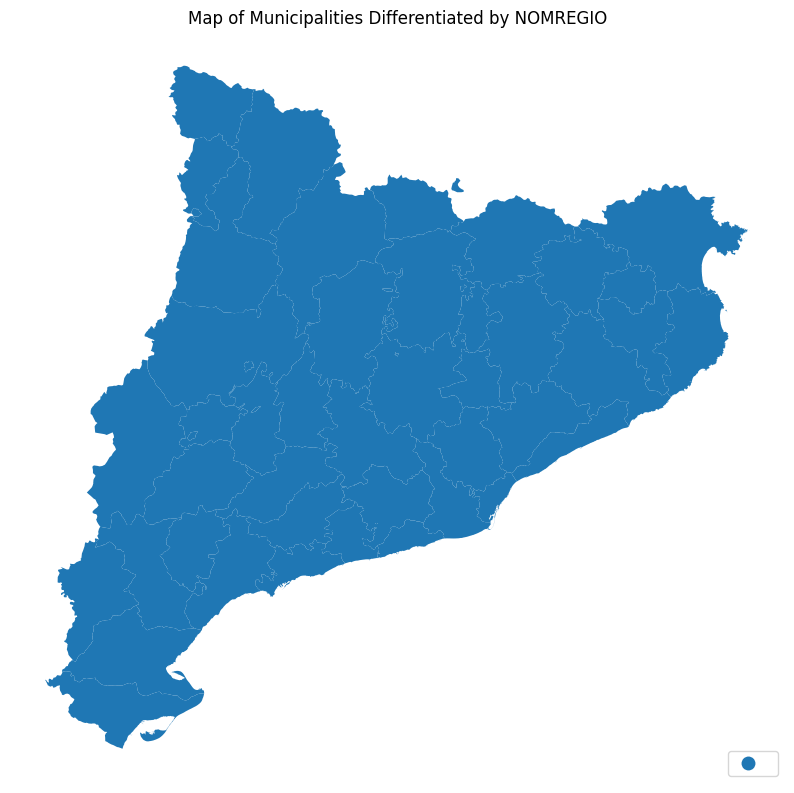

In [58]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
mncps.plot(column='NOMREGIO', ax=ax, legend=True, cmap='tab20', legend_kwds={'loc': 'lower right'})

# Customize the plot
plt.title('Map of Municipalities Differentiated by NOMREGIO')
plt.axis('off')  # Turn off the axes
plt.show()